# Setup

### Import cac thu vien can thiet

In [3]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchinfo import summary
from tqdm import tqdm

### Set device gpu

In [4]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Config

In [5]:
train_dir="archive/dataset/train"
valid_dir="archive/dataset/valid"
test_dir="archive/dataset/test"

### Sumarry data

In [6]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [7]:
walk_through_dir(train_dir)

There are 2 directories and 0 images in 'archive/dataset/train'.
There are 0 directories and 197826 images in 'archive/dataset/train/real'.
There are 0 directories and 155000 images in 'archive/dataset/train/fake'.


In [8]:
walk_through_dir(valid_dir)

There are 2 directories and 0 images in 'archive/dataset/valid'.
There are 0 directories and 44258 images in 'archive/dataset/valid/real'.
There are 0 directories and 32500 images in 'archive/dataset/valid/fake'.


In [9]:
walk_through_dir(test_dir)

There are 2 directories and 0 images in 'archive/dataset/test'.
There are 0 directories and 44213 images in 'archive/dataset/test/real'.
There are 0 directories and 32500 images in 'archive/dataset/test/fake'.


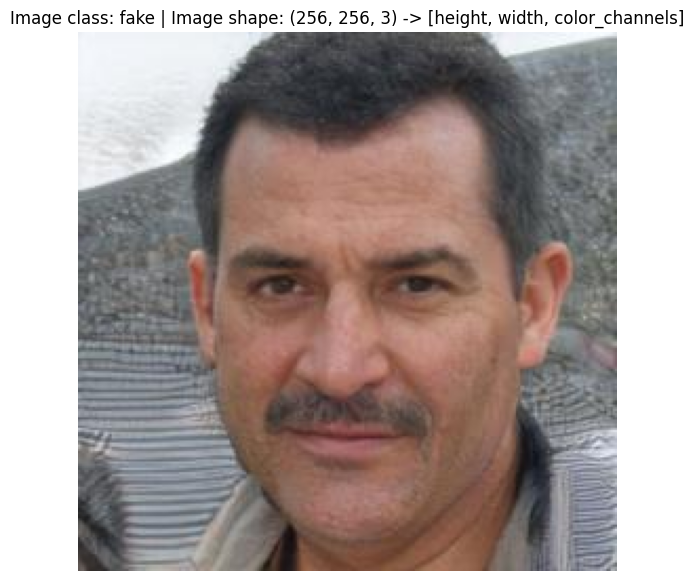

In [10]:
import os
from pathlib import Path

# Define the train directory as a Path object
data_dir = Path(train_dir)

import random
from PIL import Image

# Set seed
random.seed(42) # <- try changing this and see what happens

import random

# Get all image paths
image_path_list = list(data_dir.glob("**/*.jpg"))
# Get a random index
random_index = random.randint(0, len(image_path_list) - 1)
# Get the image at the random index
random_image_path = image_path_list[random_index]

# 4. Open image
img = Image.open(random_image_path)

import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)
image_class = random_image_path.parent.stem

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);


### Train, Test Function

In [11]:
def load_checkpoint(checkpoint_path, model, optimizer):
    """
    Load model and optimizer state from a checkpoint.

    Args:
        checkpoint_path (str): Path to the checkpoint file.
        model (torch.nn.Module): The model to load the state into.
        optimizer (torch.optim.Optimizer): The optimizer to load the state into.

    Returns:
        model (torch.nn.Module): The model with loaded state.
        optimizer (torch.optim.Optimizer): The optimizer with loaded state.
        epoch (int): The epoch at which the checkpoint was saved.
    """
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    return model, optimizer, epoch

In [12]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for (X, y) in tqdm(dataloader, desc="Batch"):
        # Send data to target device
        # print("\rbatch: " + str(batch) + "/" + str(round(int(100000/64))), end = "")
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)
        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [13]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [14]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          checkpoint_model_name: str = "",
          epochs: int = 5):
    # 1. Take in various parameters required for training and test steps

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in range(epochs):
        print("Epoch:",epoch + 1)
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        # 6. Save Checkpoints
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'train_acc': train_acc,
            'test_loss': test_loss,
            'test_acc': test_acc
        }
        torch.save(checkpoint, f"checkpoints/{checkpoint_model_name}_epoch_{epoch+1}.pth")
        
    # 7. Return the filled results at the end of the epochs
    return results

# Model

### Resnet50

In [5]:
weights=torchvision.models.ResNet50_Weights.DEFAULT
weights

ResNet50_Weights.IMAGENET1K_V2

In [6]:
auto_transforms=weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
from torch.utils.data import random_split, DataLoader

# Giả sử train_data là một đối tượng của datasets.ImageFolder
train_data = datasets.ImageFolder(root=train_dir, transform=auto_transforms)

# Tính toán số lượng mẫu cần giữ lại (10% của tổng số mẫu)
num_samples = len(train_data)
num_train_samples = int(0.01 * num_samples)
num_val_samples = num_samples - num_train_samples

# Chia dữ liệu ngẫu nhiên thành tập huấn luyện và tập validation
train_data, _ = random_split(train_data, [num_train_samples, num_val_samples])

# Tạo DataLoader cho tập huấn luyện
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
# In ra số lượng mẫu trong tập huấn luyện sau khi giảm
print(f"Number of samples in the reduced training set: {len(train_data)}")
test_data = train_data

Number of samples in the reduced training set: 3528


In [55]:
test_data = train_data

In [56]:
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=auto_transforms, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(test_dir,
                                 transform=auto_transforms)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 352826
    Root location: archive/dataset/train
    StandardTransform
Transform: ImageClassification(
               crop_size=[224]
               resize_size=[232]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BILINEAR
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 76713
    Root location: archive/dataset/test
    StandardTransform
Transform: ImageClassification(
               crop_size=[224]
               resize_size=[232]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BILINEAR
           )


In [57]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE, # how many samples per batch?
                              num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7e2c83283d00>,
 <torch.utils.data.dataloader.DataLoader at 0x7e2c83283d60>)

In [15]:
weights=torchvision.models.ResNet50_Weights.DEFAULT
model_resnet50=torchvision.models.resnet50(weights=weights).to(device)
for param in model_resnet50.parameters():
    param.requires_grad = False
# model_resnet50= nn.Sequential(*list(model_resnet50.children())[:-1])
# model_resnet50.fc= torch.nn.Sequential(
#     torch.nn.Linear(2048,1024),
#     torch.nn.ReLU(),
#     torch.nn.Linear(1024,512),
#     torch.nn.Dropout(),
#     torch.nn.Linear(512,2,)
#     ).to(device)

In [16]:
BATCH_SIZE=32
summary(model_resnet50,
        input_size=(BATCH_SIZE, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 1000]           --                   False
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (4,096)              False
│    │    └─

In [ ]:
for param in model_resnet50.parameters():
    param.requires_grad = TRAINABLE_EXTRACTOR

In [70]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_resnet50.fc= torch.nn.Sequential(
    torch.nn.Linear(2048,1000),
    torch.nn.ReLU(),
    torch.nn.Linear(1000,500),
    torch.nn.Dropout(),
    torch.nn.Linear(in_features=500,
                    out_features=output_shape,
                    bias=True)
    ).to(device)

for param in model_resnet50.fc.parameters():
    param.requires_grad = TRAINABLE_CLASSIFIER

In [63]:
summary(model_resnet50,
        input_size=(BATCH_SIZE, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 2]              --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (4,096)              False
│    │    

# Resnet50

## Training

In [1]:
def load_checkpoint(checkpoint_path, model, optimizer):
    """
    Load model and optimizer state from a checkpoint.

    Args:
        checkpoint_path (str): Path to the checkpoint file.
        model (torch.nn.Module): The model to load the state into.
        optimizer (torch.optim.Optimizer): The optimizer to load the state into.

    Returns:
        model (torch.nn.Module): The model with loaded state.
        optimizer (torch.optim.Optimizer): The optimizer with loaded state.
        epoch (int): The epoch at which the checkpoint was saved.
    """
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    return model, optimizer, epoch

In [1]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for (X, y) in tqdm(dataloader, desc="Batch"):
        # Send data to target device
        # print("\rbatch: " + str(batch) + "/" + str(round(int(100000/64))), end = "")
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

NameError: name 'torch' is not defined

In [125]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [126]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    # 1. Take in various parameters required for training and test steps

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in range(epochs):
        print("Epoch:",epoch + 1)
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        # 6. Save Checkpoints
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'train_acc': train_acc,
            'test_loss': test_loss,
            'test_acc': test_acc
        }
        torch.save(checkpoint, f"checkpoints/resnet50_epoch_{epoch+1}.pth")
        
    # 7. Return the filled results at the end of the epochs
    return results

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 10

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_resnet50.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()
# Train model_0
results = train(model=model_resnet50,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

Epoch: 1


Batch: 100%|██████████| 111/111 [00:22<00:00,  4.99it/s]


Epoch: 1 | train_loss: 0.1148 | train_acc: 0.9561 | test_loss: 0.0824 | test_acc: 0.9665
Epoch: 2


Batch:  75%|███████▍  | 83/111 [00:16<00:05,  4.89it/s]


KeyboardInterrupt: 

## Plot loss curves

In [ ]:
import typing
from typing import Dict, List

In [ ]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

In [ ]:
plot_loss_curves(results)

NameError: name 'results' is not defined

## Demo Test

In [80]:
custom_image_path='examples/02864.jpg'

In [81]:
import torchvision

custom_image_uint8=torchvision.io.read_image(str(custom_image_path))

print(f"Custom image tensor:\n{custom_image_uint8}")
print(f"Custom image shape: {custom_image_uint8.shape}\n")
print(f"Custom image datatype: {custom_image_uint8.dtype}")

Custom image tensor:
tensor([[[135, 129, 128,  ...,  40,  39,  42],
         [128, 122, 125,  ...,  37,  35,  38],
         [123, 124, 124,  ...,  35,  35,  38],
         ...,
         [ 83,  94,  52,  ..., 118,  52,  30],
         [ 63,  83,  51,  ..., 171, 124,  52],
         [ 68,  53,  51,  ..., 188, 170,  89]],

        [[127, 121, 123,  ...,  61,  65,  70],
         [124, 118, 122,  ...,  56,  59,  65],
         [126, 127, 125,  ...,  50,  52,  58],
         ...,
         [109, 120,  78,  ...,  86,  40,  30],
         [ 89, 109,  77,  ..., 123,  96,  34],
         [ 94,  79,  77,  ..., 132, 133,  61]],

        [[125, 119, 119,  ...,  28,  26,  29],
         [121, 115, 117,  ...,  24,  23,  24],
         [119, 120, 119,  ...,  21,  20,  21],
         ...,
         [132, 143, 101,  ...,  87,  24,   4],
         [114, 134, 102,  ..., 139,  95,  24],
         [119, 104, 102,  ..., 157, 140,  58]]], dtype=torch.uint8)
Custom image shape: torch.Size([3, 256, 256])

Custom image dataty

In [82]:
custom_image=torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

custom_image=custom_image/255

print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor:
tensor([[[0.5294, 0.5059, 0.5020,  ..., 0.1569, 0.1529, 0.1647],
         [0.5020, 0.4784, 0.4902,  ..., 0.1451, 0.1373, 0.1490],
         [0.4824, 0.4863, 0.4863,  ..., 0.1373, 0.1373, 0.1490],
         ...,
         [0.3255, 0.3686, 0.2039,  ..., 0.4627, 0.2039, 0.1176],
         [0.2471, 0.3255, 0.2000,  ..., 0.6706, 0.4863, 0.2039],
         [0.2667, 0.2078, 0.2000,  ..., 0.7373, 0.6667, 0.3490]],

        [[0.4980, 0.4745, 0.4824,  ..., 0.2392, 0.2549, 0.2745],
         [0.4863, 0.4627, 0.4784,  ..., 0.2196, 0.2314, 0.2549],
         [0.4941, 0.4980, 0.4902,  ..., 0.1961, 0.2039, 0.2275],
         ...,
         [0.4275, 0.4706, 0.3059,  ..., 0.3373, 0.1569, 0.1176],
         [0.3490, 0.4275, 0.3020,  ..., 0.4824, 0.3765, 0.1333],
         [0.3686, 0.3098, 0.3020,  ..., 0.5176, 0.5216, 0.2392]],

        [[0.4902, 0.4667, 0.4667,  ..., 0.1098, 0.1020, 0.1137],
         [0.4745, 0.4510, 0.4588,  ..., 0.0941, 0.0902, 0.0941],
         [0.4667, 0.4706, 0.4667,  ..

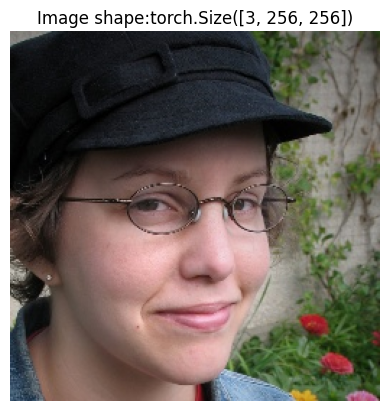

In [83]:
plt.imshow(custom_image.permute(1,2,0))
plt.title(f"Image shape:{custom_image.shape}")
plt.axis(False);

In [84]:
custom_image_transform=transforms.Compose([
    transforms.Resize((64,64))
])

custom_image_transformed=custom_image_transform(custom_image)

print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 256, 256])
New shape: torch.Size([3, 64, 64])


In [86]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device: torch.device = device):
    """Makes a prediction on a target image and plots the image with its prediction."""

    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255.

    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))

    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);

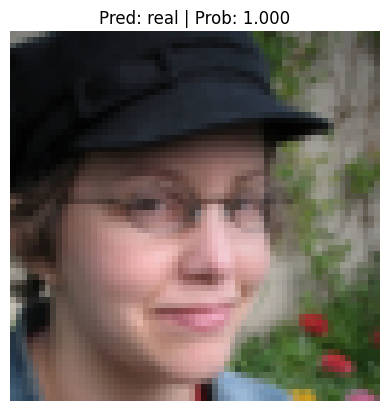

In [ ]:
# Pred on our custom image
pred_and_plot_image(model=model_resnet50,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)

In [88]:
img='/content/images (3).jpeg'

In [ ]:
pred_and_plot_image(model=model_resnet50,
                    image_path=img,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)

In [ ]:
vk='/content/Virat_Kohli_during_the_India_vs_Aus_4th_Test_match_at_Narendra_Modi_Stadium_on_09_March_2023.jpg'

In [ ]:
pred_and_plot_image(model=model_resnet50,
                    image_path=vk,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)

In [91]:
val='/content/real_00015.jpg'

In [ ]:
pred_and_plot_image(model=model_resnet50,
                    image_path=val,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)


In [ ]:
modi='/content/Modi_tendering_his_resignation_to_the_President_(cropped).jpg'

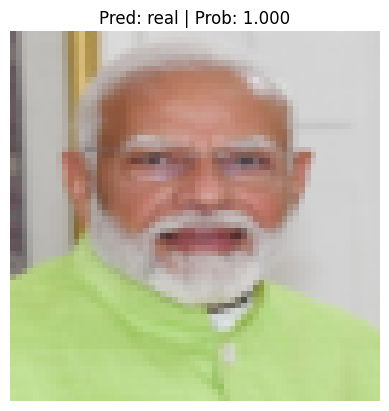

In [ ]:
pred_and_plot_image(model=model_resnet50,
                    image_path=modi,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)

In [ ]:
ai='/content/1_vW234iL2w0KbhNdMuc0O1w.jpg'

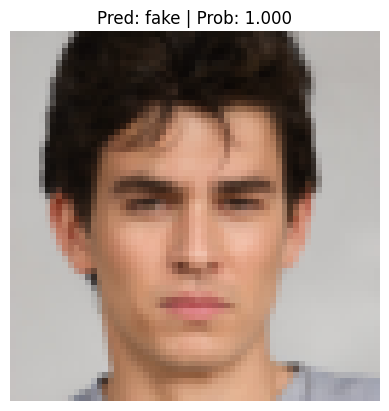

In [ ]:
pred_and_plot_image(model=model_resnet50,
                    image_path=ai,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)

In [ ]:
ai2="/content/ai-generated-portrait-of-a-young-man-no-facial-expression-facing-the-camera-isolated-white-background-ai-generative-photo.jpg"

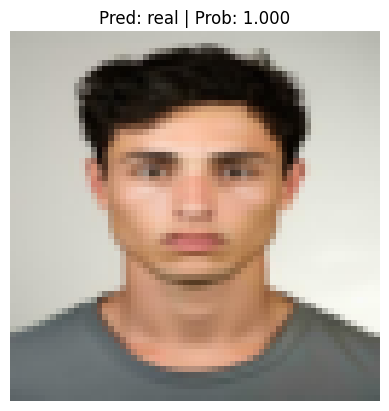

In [ ]:
pred_and_plot_image(model=model_resnet50,
                    image_path=ai2,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)

In [ ]:
dw="/content/download.jpeg"

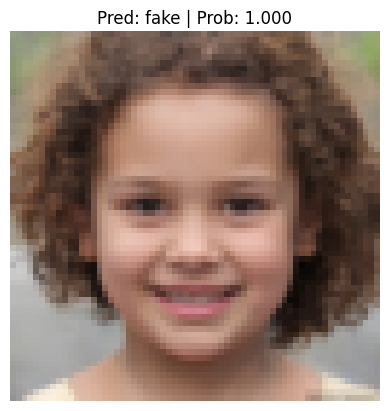

In [ ]:
pred_and_plot_image(model=model_resnet50,
                    image_path=dw,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)

In [ ]:
dn="/content/download (1).jpeg"

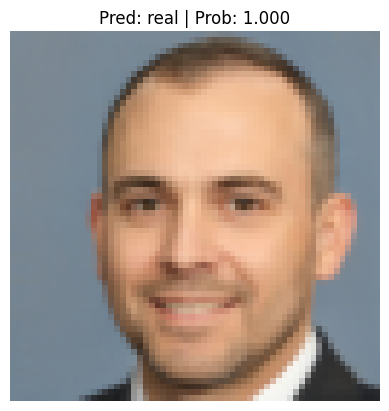

In [ ]:
pred_and_plot_image(model=model_resnet50,
                    image_path=dn,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)

In [ ]:
di="/content/download (2).jpeg"

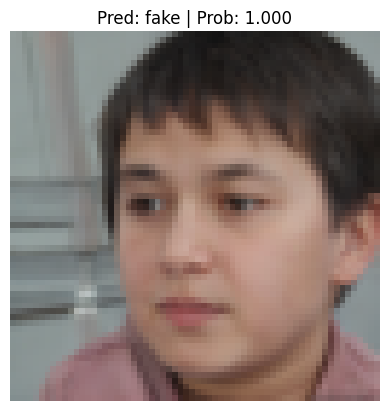

In [ ]:
pred_and_plot_image(model=model_resnet50,
                    image_path=di,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)

In [ ]:
a1="/content/download (3).jpeg"

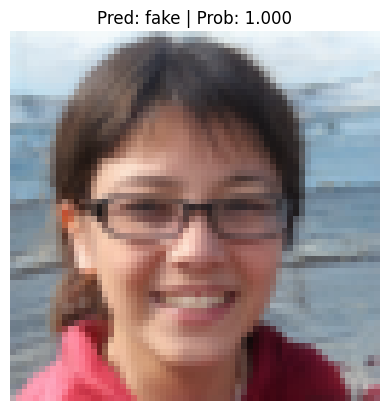

In [ ]:
pred_and_plot_image(model=model_resnet50,
                    image_path=a1,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)

In [ ]:
a2="/content/download (4).jpeg"

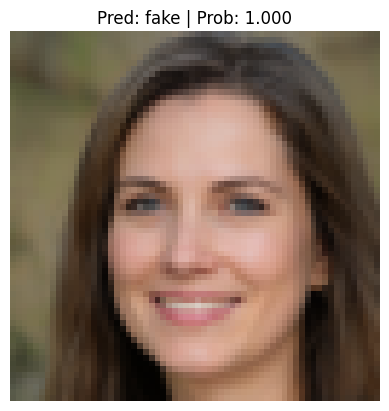

In [ ]:
pred_and_plot_image(model=model_resnet50,
                    image_path=a2,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)

In [ ]:
mamu="/content/Mamu.jpg"

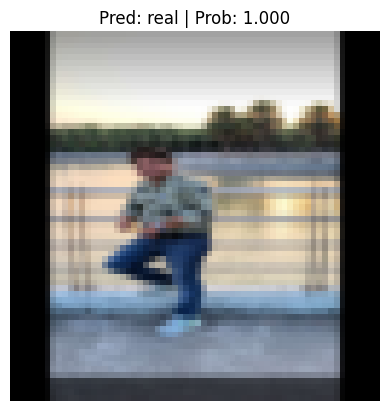

In [ ]:
pred_and_plot_image(model=model_resnet50,
                    image_path=mamu,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)

In [ ]:
a3="/content/download (5).jpeg"

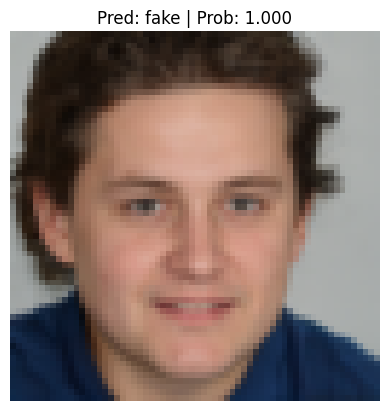

In [ ]:
pred_and_plot_image(model=model_resnet50,
                    image_path=a3,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)

## Test

In [93]:
try:
  import gradio as gd
except:
  !pip install gradio
  import gradio as gr

print(f"Gradio version:{gr.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 MB 17.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.3/130.3 KB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 751.2/751.2 KB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 22.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.7/431.7 KB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 KB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.1/322.1 KB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 KB 12.5 MB/s eta 0:00:00
  Using cached httpx-0.28.1-py3-none-any.whl (73 kB)
  Using cached anyio-4.8.0-py3-none-any.whl (96 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 21.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1

/home/dungnd/Documents/AI/fake-faces-detection/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


KeyboardInterrupt: 

In [ ]:
model_resnet50.to('cpu')

next(iter(model_resnet50.parameters())).device

device(type='cpu')

In [ ]:
from typing import Tuple, Dict

def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()

    # Transform the target image and add a batch dimension
    img = auto_transforms(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    model_resnet50.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(model_resnet50(img), dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

In [ ]:
test_dir='/content/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test'

In [ ]:
import random
from PIL import Image

# Get a list of all test image filepaths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

# Randomly select a test image path
random_image_path = random.sample(test_data_paths, k=1)[0]

# Open the target image
image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}\n")

# Predict on the target image and print out the outputs
pred_dict, pred_time = predict(img=image)
print(f"Prediction label and probability dictionary: \n{pred_dict}")
print(f"Prediction time: {pred_time} seconds")

[INFO] Predicting on image at path: /content/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/fake/CYMWHHQUYO.jpg

Prediction label and probability dictionary: 
{'fake': 0.9999924898147583, 'real': 7.5066977842652705e-06}
Prediction time: 0.33528 seconds


In [ ]:
# Create a list of example inputs to our Gradio demo
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
example_list

[['/content/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/fake/CSFEIYUG1J.jpg'],
 ['/content/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/real/15266.jpg'],
 ['/content/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/fake/OS20LOPU8W.jpg']]

In [ ]:
import gradio as gr

# Create title, description and article strings
title = "Real Or Fake"
description = "A computer vision model to classify images of as Real Or Fake (Generated By Ai)"
article = "Created at [Flower Classification]."

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=2, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch(debug=False, # print errors locally?
            share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://1350620282c6a6d48e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [95]:
import shutil
from pathlib import Path

real_or_fake_demo_path=Path('demos/real_or_fake')

if real_or_fake_demo_path.exists():
  shutil.rmtree(real_or_fake_demo_path)
  real_or_fake_demo_path.mkdir(parents=True,
                                        exist_ok=True)
else:
  real_or_fake_demo_path.mkdir(parents=True,
                                        exist_ok=True)


!ls demos/real_or_fake/

In [ ]:
import shutil
from pathlib import Path

# 1. Create an examples directory
real_or_fake_examples_path = real_or_fake_demo_path / "examples"
real_or_fake_examples_path.mkdir(parents=True, exist_ok=True)

# 2. Collect three random test dataset image paths
real_or_fake_examples = [Path('/content/Images/val/rose/8524505682_bda885af3a_n.jpg'),
                            Path('/content/Images/val/daisy/754296579_30a9ae018c_n.jpg'),
                            Path('/content/Images/val/tulip/20435554843_ba6862f923_n.jpg')]

# 3. Copy the three random images to the examples directory
for example in real_or_fake_examples:
    destination = real_or_fake_examples_path / example.name
    print(f"[INFO] Copying {example} to {destination}")
    shutil.copy2(src=example, dst=destination)

In [ ]:
import os

# Get example filepaths in a list of lists
example_list = [["examples/" + example] for example in os.listdir(real_or_fake_examples_path)]
example_list


## save Checkpoint

In [ ]:
from pathlib import Path

Model_Path=Path("Models")
Model_Path.mkdir(parents=True,
                 exist_ok=True)

Model_Name="RealityCheck.pth"
Model_Save_Path=Model_Path/Model_Name

print(f"Saving Model to : {Model_Save_Path}")
torch.save(obj=model_resnet50.state_dict(),
           f=Model_Save_Path)

Saving Model to : Models/RealityCheck.pth


In [96]:
import shutil

# Create a source path for our target model
model_real_or_fake_model_path = "checkpoints/resnet50_epoch_1.pth"

# Create a destination path for our target model
model_real_or_fake_model_destination = real_or_fake_demo_path / model_real_or_fake_model_path.split("/")[1]

# Try to move the file
try:
    print(f"[INFO] Attempting to move {model_real_or_fake_model_path} to {model_real_or_fake_model_destination}")

    # Move the model
    shutil.move(src=model_real_or_fake_model_path,
                dst=model_real_or_fake_model_destination)

    print(f"[INFO] Model move complete.")

# If the model has already been moved, check if it exists
except:
    print(f"[INFO] No model found at {model_real_or_fake_model_path}, perhaps its already been moved?")
    print(f"[INFO] Model exists at {model_real_or_fake_model_destination}: {model_real_or_fake_model_destination.exists()}")

[INFO] Attempting to move checkpoints/resnet50_epoch_1.pth to demos/real_or_fake/resnet50_epoch_1.pth
[INFO] Model move complete.


In [33]:
class_names=train_data.classes
class_names

['fake', 'real']

In [ ]:
%%writefile demos/real_or_fake/model.py

import torch
import torchvision
from torch import nn

def create_model(num_classes:int=2,
                 seed:int=42):
  weights=torchvision.models.ResNet50_Weights.DEFAULT
  transforms=weights.transforms
  model=torchvision.models.resnet50(weights=weights)

  for param in model.parameters():
    param.requires_grad=False

  torch.manual_seed(42)
  model.fc= torch.nn.Sequential(
    torch.nn.Linear(2048,1000),
    torch.nn.ReLU(),
    torch.nn.Linear(1000,500),
    torch.nn.Dropout(),
    torch.nn.Linear(in_features=500,
                    out_features=output_shape,
                    bias=True)

    )

  return model,transforms



In [ ]:
%%writefile demos/real_or_fake/app.py

import gradio as gr
import os
import torch

from model import create_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
class_names = ['Real', 'Fake']

### 2. Model and transforms preparation ###

# Create model
model, model_transforms = create_model(
    num_classes=2,
)

# Load saved weights
model.load_state_dict(
    torch.load(
        f="RealityCheck.pth",
        map_location=torch.device("cpu"),  # load to CPU
    )
)

### 3. Predict function ###

# Create predict function
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()

    # Transform the target image and add a batch dimension
    img = model_transforms(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    model.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(model(img), dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article strings
title = "Reality Check"
description = "An computer vision model to classify images as Real Or Fake(Ai Generated). The Model can classify the images with 95% Accuracy"
article = "Created at [Real Or Fake]"

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=2, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    # Create examples list from "examples/" directory
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch()

In [ ]:
%%writefile demos/flower_classification/requirements.txt
torch==2.3.0
torchvision==0.18.0
gradio==4.32.2

In [37]:
!ls demos/real_or_fake

ls: cannot access 'demos/real_or_fake': No such file or directory


In [ ]:
# Change into and then zip the foodvision_mini folder but exclude certain files
!cd demos/real_or_fake && zip -r ../real_or_fake.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

# Download the zipped FoodVision Mini app (if running in Google Colab)
try:
    from google.colab import files
    files.download("demos/real_or_fake.zip")
except:
    print("Not running in Google Colab, can't use google.colab.files.download(), please manually download.")

# EfficientNetV2-S

### Config

In [53]:
BATCH_SIZE = 32

TRAINABLE_EXTRACTOR = False
TRAINABLE_CLASSIFIER = True

NUM_EPOCHS = 10

### Data Loader

In [26]:
from torchvision import datasets

weights = torchvision.models.EfficientNet_V2_S_Weights.DEFAULT
auto_transforms = weights.transforms()

train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=auto_transforms, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(test_dir,
                                 transform=auto_transforms)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 352826
    Root location: archive/dataset/train
    StandardTransform
Transform: ImageClassification(
               crop_size=[384]
               resize_size=[384]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BILINEAR
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 76713
    Root location: archive/dataset/test
    StandardTransform
Transform: ImageClassification(
               crop_size=[384]
               resize_size=[384]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BILINEAR
           )


In [27]:
# cell nhap, giam so luong data de test code training
from torch.utils.data import random_split, DataLoader

# Giả sử train_data là một đối tượng của datasets.ImageFolder
train_data = datasets.ImageFolder(root=train_dir, transform=auto_transforms)

# Tính toán số lượng mẫu cần giữ lại (10% của tổng số mẫu)
num_samples = len(train_data)
num_train_samples = int(0.01 * num_samples)
num_val_samples = num_samples - num_train_samples

# Chia dữ liệu ngẫu nhiên thành tập huấn luyện và tập validation
train_data, _ = random_split(train_data, [num_train_samples, num_val_samples])

# Tạo DataLoader cho tập huấn luyện
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
# In ra số lượng mẫu trong tập huấn luyện sau khi giảm
print(f"Number of samples in the reduced training set: {len(train_data)}")
test_data = train_data

Number of samples in the reduced training set: 3528


In [28]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE, # how many samples per batch?
                              num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x703c44c742b0>,
 <torch.utils.data.dataloader.DataLoader at 0x703c44c76200>)

### Init model

In [72]:
import torch
from torch import nn

def init_model_efficientnet_v2_s(trainable = False):
    """
    Create an EfficientNetV2-S model.

    Returns:
        model (torch.nn.Module): EfficientNetV2-S model.
    """
    weights = torchvision.models.EfficientNet_V2_S_Weights.DEFAULT
    model = torchvision.models.efficientnet_v2_s(weights=weights).to(device)
    
    # Freeze all layers
    for param in model.parameters():
        param.requires_grad = trainable
    
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)
    
    # Recreate the classifier layer and seed it to the target device
    
    return model

# Example usage:
model_efficientnetv2_s = init_model_efficientnet_v2_s(TRAINABLE_EXTRACTOR)


In [73]:
summary(model_efficientnetv2_s,
       input_size=(BATCH_SIZE, 3, 224, 224),
       verbose=0,
       col_names=["input_size", "output_size", "num_params", "trainable"],
       col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   False
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 24, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 24, 112, 112]   (648)                False
│    │    └─BatchNorm2d (1)                                  [32, 24, 112, 112]   [32, 24, 112, 112]   (48)                 False
│    │    └─SiLU (2)                                         [32, 24, 112, 112]   [32, 24, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 24, 112, 112]   [32, 24

In [74]:
model_efficientnetv2_s.classifier= nn.Sequential(
    torch.nn.Linear(1280,1000),
    torch.nn.ReLU(),
    torch.nn.Linear(1000,500),
    torch.nn.Dropout(),
    torch.nn.Linear(in_features=500,
                    out_features=2,
                    bias=True)
    ).to(device)

In [71]:
summary(model_efficientnetv2_s,
       input_size=(BATCH_SIZE, 3, 224, 224),
       verbose=0,
       col_names=["input_size", "output_size", "num_params", "trainable"],
       col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 2]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 24, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 24, 112, 112]   (648)                False
│    │    └─BatchNorm2d (1)                                  [32, 24, 112, 112]   [32, 24, 112, 112]   (48)                 False
│    │    └─SiLU (2)                                         [32, 24, 112, 112]   [32, 24, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 24, 112, 112]   [32, 

### Training

In [ ]:
from timeit import default_timer as timer
start_time = timer()

torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_efficientnetv2_s.parameters(), lr=0.001)

results = train(model=model_efficientnetv2_s,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        checkpoint_model_name="EfficientNetV2_S",
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

: 

# Transformer

### Init Model

In [30]:
import torch
from torch import nn
import torchvision
from torchvision import models

def create_vit_model(tranable_extractor:bool=False):
    """
    Create a Vision Transformer (ViT) model.

    Args:
        num_classes (int): Number of classes for the final fully connected layer.
        device (torch.device): The device to run the model on.

    Returns:
        model (torch.nn.Module): Vision Transformer model.
    """
    weights = models.ViT_B_16_Weights.DEFAULT
    model = models.vit_b_16(weights=weights).to(device)
    
    # Freeze all layers
    for param in model.parameters():
        param.requires_grad = tranable_extractor
    
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)
    
    # Recreate the classifier layer and seed it to the target device
    model.heads = nn.Sequential(
        nn.Linear(model.heads.head.in_features, 1000),
        nn.ReLU(),
        nn.Linear(1000, 500),
        nn.ReLU(),
        nn.Linear(500, 2, bias=True)
    ).to(device)
    
    return model

In [31]:
BATCH_SIZE = 16

In [32]:
model_ViT_B_16 = create_vit_model(tranable_extractor=False)

In [33]:
summary(model_ViT_B_16,
        input_size=(BATCH_SIZE, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [16, 3, 224, 224]    [16, 2]              768                  Partial
├─Conv2d (conv_proj)                                         [16, 3, 224, 224]    [16, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [16, 197, 768]       [16, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [16, 197, 768]       [16, 197, 768]       --                   --
│    └─Sequential (layers)                                   [16, 197, 768]       [16, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [16, 197, 768]       [16, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [16, 197, 768]       [16, 

In [34]:
def load_data(train_dir: str, valid_dir: str, batch_size: int = 64):
    # Define transforms
    weights = torchvision.models.EfficientNet_V2_S_Weights.DEFAULT
    auto_transforms = weights.transforms()

    # Load data
    train_data = datasets.ImageFolder(train_dir, transform=auto_transforms, target_transform = None)
    valid_data = datasets.ImageFolder(valid_dir, transform=auto_transforms)

    # Create data loaders
    train_dataloader = DataLoader(train_data, batch_size=batch_size, num_workers=1, shuffle=True)
    valid_dataloader = DataLoader(valid_data, batch_size=batch_size, num_workers=1, shuffle=False)

    return train_dataloader, valid_dataloader

In [35]:
train_dir="archive/dataset/train"
valid_dir="archive/dataset/valid"
test_dir="archive/dataset/test"
# Train
train_dataloader, test_dataloader = load_data(train_dir, valid_dir, BATCH_SIZE)

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def check_image_sizes(data_dir: str, batch_size: int = 64):
    # Define transforms with resizing
    # transform = transforms.Compose([
    #     transforms.Resize((224, 224)),  # Resize images to 224x224
    #     transforms.ToTensor()  # Convert images to PyTorch tensors
    # ])
    weights = torchvision.models.EfficientNet_V2_S_Weights.DEFAULT
    auto_transforms = weights.transforms()

    # Load data
    # train_data = datasets.ImageFolder(train_dir, transform=auto_transforms, target_transform = None)
    # valid_data = datasets.ImageFolder(valid_dir, transform=auto_transforms)

    # Load dataset
    dataset = datasets.ImageFolder(data_dir, transform=auto_transforms)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # Check image sizes
    for batch_idx, (X, y) in enumerate(dataloader):
        print(f"Batch {batch_idx + 1}:")
        for i in range(X.size(0)):  # Loop through each image in the batch
            print(f"Image {i + 1} size: {X[i].shape}")  # Print size of each image
        break  # Remove this line if you want to check all batches

# Example usage
train_dir = "archive/dataset/train"
check_image_sizes(train_dir)

Batch 1:
Image 1 size: torch.Size([3, 384, 384])
Image 2 size: torch.Size([3, 384, 384])
Image 3 size: torch.Size([3, 384, 384])
Image 4 size: torch.Size([3, 384, 384])
Image 5 size: torch.Size([3, 384, 384])
Image 6 size: torch.Size([3, 384, 384])
Image 7 size: torch.Size([3, 384, 384])
Image 8 size: torch.Size([3, 384, 384])
Image 9 size: torch.Size([3, 384, 384])
Image 10 size: torch.Size([3, 384, 384])
Image 11 size: torch.Size([3, 384, 384])
Image 12 size: torch.Size([3, 384, 384])
Image 13 size: torch.Size([3, 384, 384])
Image 14 size: torch.Size([3, 384, 384])
Image 15 size: torch.Size([3, 384, 384])
Image 16 size: torch.Size([3, 384, 384])
Image 17 size: torch.Size([3, 384, 384])
Image 18 size: torch.Size([3, 384, 384])
Image 19 size: torch.Size([3, 384, 384])
Image 20 size: torch.Size([3, 384, 384])
Image 21 size: torch.Size([3, 384, 384])
Image 22 size: torch.Size([3, 384, 384])
Image 23 size: torch.Size([3, 384, 384])
Image 24 size: torch.Size([3, 384, 384])
Image 25 size: t

: 

In [36]:
# Train
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 10

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_ViT_B_16.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()
# Train model_0
results = train(model=model_ViT_B_16,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        checkpoint_model_name="ViT_B_16",
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

Epoch: 1


Batch:   0%|          | 0/22052 [00:00<?, ?it/s]


AssertionError: Wrong image height! Expected 224 but got 384!